In [1]:
"""
I want to distinguish real clusters from fake clusters

I can stack the non-detection images and verify if there is an object

I can stack the likelihood in the non-detection images
"""

'\nI want to distinguish real clusters from fake clusters\n\nI can stack the non-detection images and verify if there is an object\n\nI can stack the likelihood in the non-detection images\n'

In [2]:
from salad.serialize import read, write
from salad.analysis.plot import plot_cluster, plot_result, plot_fake, plot_catalog
import astropy.table
import os
from functools import lru_cache
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import numpy as np
import astropy.units as u

In [3]:
clusters = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined.pkl")
images = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/images.pkl")

In [7]:
cluster = read("/epyc/projects/salad/search/new_pipeline/DEEP/20190403/A0c/detector_1/snr_3.0/unshuffled/refined_clusters_2_filtered_joined_split/cluster_21.pkl")

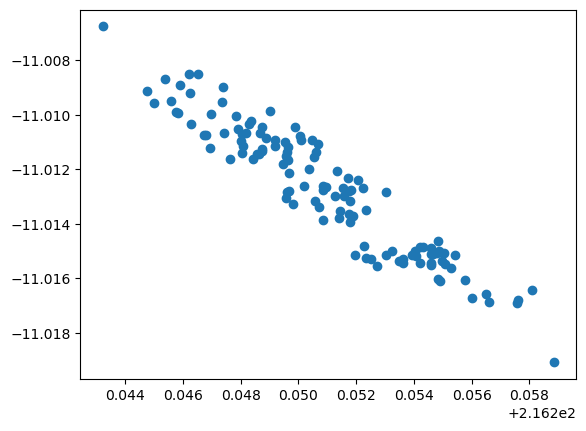

In [8]:
plot_cluster(cluster)

In [129]:
cluster.extra['line'].alpha, cluster.extra['line'].beta

(<Quantity [12837.11188574, -2368.62273619] deg>,
 <Quantity [[-0.21545842,  0.0402475 ]] deg / d>)

In [131]:
cluster = clusters.clusters[0]
cluster.extra['line'].alpha, cluster.extra['line'].beta

(<Quantity [12837.11188574, -2368.62273619] deg>,
 <Quantity [[-0.21545842,  0.0402475 ]] deg / d>)

In [135]:
import lsst.geom

def get_positions(cluster, times):
    line = cluster.extra['line']
    positions = (times[:, None] @ line.beta) + line.alpha
    return positions


positions = get_positions(cluster, times)
points = []
cutout_width = 50
cutout_height = 50
for position, exposure in zip(positions, exposures):
    wcs = image.reader.readWcs()
    exposure_bbox = exposure.getBBox()
    point = wcs.skyToPixel(lsst.geom.SpherePoint(position[0].to(u.deg).value, position[1].to(u.deg).value, units=lsst.geom.degrees))
    points.append(point)

In [136]:
from salad.measure.fitting import fit_trajectory

line = cluster.extra['line']
trajectory_fit = fit_trajectory(
    exposures, points, times.value, 
    lambda p, t : (p[0] * t + p[2], p[1] * t + p[3]), 
    start=np.hstack([line.beta.value.flatten(), line.alpha.value.flatten()])
)

/epyc/projects/salad/src/salad/measure/fitting.py:22: RuntimeWarning: invalid value encountered in scalar divide
  f = c/a # flux estimate; Whidden et al. 2019 Eq. 22 (alpha_ML)
/epyc/projects/salad/src/salad/measure/fitting.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = 1/np.sqrt(a) # standard deviation in flux estimate
/epyc/projects/salad/src/salad/measure/fitting.py:24: RuntimeWarning: invalid value encountered in scalar divide
  snr = c / np.sqrt(a) # signal to noise -- why is this not f / sigma?; Whidden et al. 2019 Eq. 26 (nu_coadd)
/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [139]:
np.hstack([line.beta.value.flatten(), line.alpha.value.flatten()])

array([-2.15458421e-01,  4.02475004e-02,  1.28371119e+04, -2.36862274e+03])

In [141]:
trajectory_fit

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: inf
             x: [-2.155e-01  4.226e-02  1.284e+04 -2.369e+03]
           nit: 133
          nfev: 800
 final_simplex: (array([[-2.155e-01,  4.226e-02,  1.284e+04, -2.369e+03],
                       [-2.155e-01,  4.226e-02,  1.284e+04, -2.369e+03],
                       ...,
                       [-2.155e-01,  4.226e-02,  1.284e+04, -2.369e+03],
                       [-2.155e-01,  4.226e-02,  1.284e+04, -2.369e+03]]), array([       inf,        inf,        inf,        inf,
                              inf]))

In [72]:
# load exposures into memory
exposures = np.array([image.exposure for image in images])

In [26]:
exposures[0].getInfo().getVisitInfo()

VisitInfo(exposureTime=120, darkTime=120.548, date=2019-04-04T08:10:55.754802000, UT1=nan, ERA=5.49242 rad, boresightRaDec=(216.4532340447, -11.9684451401), boresightAzAlt=(300.0530000000, +59.1100000000), boresightAirmass=1.16, boresightRotAngle=1.5708 rad, rotType=1, observatory=-30.1661N, -70.8149E  2215, weather=Weather(9.4, 77900, 68), instrumentLabel='DECam', id=845945, focusZ=2.73581, observationType='science', scienceProgram='2019A-0337', observationReason='science', object='A0c', hasSimulatedContent=false)

In [73]:
# exposures = []
expnums = []
times = []
# cutouts = []
for exposure in exposures:
    visit_info = exposure.getInfo().getVisitInfo()
    time = visit_info.date.toAstropy() + astropy.time.TimeDelta(visit_info.exposureTime / 2 + 0.5, format='sec')
    times.append(time.value)
    expnums.append(visit_info.getId())
times = np.array(times) * u.day
expnums = np.array(expnums)
idx = np.argsort(expnums)
times = times[idx]
expnums = expnums[idx]
exposures = exposures[idx]

In [67]:
matched_expnum = []
for row in cluster.points:
    # wish we included expnum as a fourth column...
    close = np.isclose(row[2], times.value, rtol=1e-8)
    if np.any(close):
        matched_expnum.append(expnums[np.where(close)][0])
        
matched_expnum = np.array(matched_expnum)
unmatched_expnum = [e for e in expnums if not np.isin(e, matched_expnum)]

In [102]:
from salad.measure.forced_line import forced_line
from salad.measure.forced import forced_exposures

def convert_zp(flux, orig, new):
    return flux * 10**(-2/5*(orig - new))

In [108]:
cluster.extra['join'].sort("exposures")

forced_logL,forced_a,forced_c,forced_flux,forced_sigma,forced_SNR,forced_mag,forced_sigma_mag_high,forced_sigma_mag_low,forced_mask,forced_zero_point,forced_i_x,forced_i_y,forced_exposure,forced_detector,forced_time
float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int64,int64,Time
-852.3674185848333,3.719785029487127e-05,0.030577614880047756,822.0263976992161,163.96119649057485,5.013542321560635,23.943307012528816,-0.2415420963244479,-0.19746421596902763,1024,31.230521423139965,594.0,2174.0,845902,1,58577.266932273415
-808.5167727025841,3.479273711202024e-05,0.028820958204524842,828.3613362102443,169.53356796790442,4.886119876666944,23.93179385779526,-0.2486198111987541,-0.20216246222228307,1024,31.227343407762106,591.0,2166.0,845903,1,58577.268642018775
-850.3642525864707,2.739806309096016e-05,0.02898803562220201,1058.0322968803753,191.0469326589891,5.538075289431205,23.645194159684785,-0.2162178970240305,-0.18022765444529654,263168,31.20644147199236,592.0,2161.0,845904,1,58577.27035653514
-865.1041425258312,4.2603642116383135e-05,0.025812896186925186,605.8847296766418,153.20630415962717,3.95469842445494,24.28506397977074,-0.3165005257060791,-0.244759636838765,1024,31.241038997170083,584.0,2092.0,845918,1,58577.29459587396
-833.7551014474184,2.3174069215878616e-05,0.032120861367899434,1386.069104596036,207.72982254780024,6.672460832036241,23.34277240012255,-0.17628631831314934,-0.15162161728784795,33792,31.197234608201228,576.0,2015.0,845937,1,58577.327197810955
-846.5637344775266,2.569076716558807e-05,0.028448804460725303,1107.355194080445,197.29290312929638,5.612747222614172,23.591121049188235,-0.2130395690249678,-0.17801609534027918,1024,31.201838416846982,569.0,2019.0,845946,1,58577.34263908185
-865.7008412899801,2.843799073233505e-05,0.028524670140566755,1003.048014504525,187.52127439991045,5.348982496596151,23.69996547949437,-0.22470879250715114,-0.18608238253868947,1024,31.20326978596184,557.0,1969.0,845947,1,58577.34471372368
-819.8334971796562,2.9413176287252995e-05,0.03152485367698714,1071.7935856063698,184.38646449847514,5.812756313331413,23.628044577695903,-0.20497061034161845,-0.1723518458464106,1024,31.20332246164791,568.0,1945.0,845950,1,58577.34989011843
-847.7700363043623,3.0278975337078348e-05,0.01659947389093143,548.2178213145944,181.73116592669896,3.016641743968767,24.353841712043447,-0.4372374593575401,-0.3108484024733542,1024,31.201224585440634,555.0,1933.0,845951,1,58577.35161455016


In [115]:
line_meas = forced_line(cluster, exposures, times)

line_meas['forced_flux_zp'] = convert_zp(line_meas['forced_flux'], line_meas['forced_zero_point'], 31)
line_meas['forced_sigma_zp'] = convert_zp(line_meas['forced_sigma'], line_meas['forced_zero_point'], 31)
line_meas['detected'] = np.hstack([np.isin(e, matched_expnum) for e in meas['forced_exposure']])

mask = line_meas['detected']
cluster.extra['join'].sort("exposures")

points_meas = forced_exposures(exposures[mask], cluster.extra['join'])
points_meas['forced_flux_zp'] = convert_zp(points_meas['forced_flux'], points_meas['forced_zero_point'], 31)
points_meas['forced_sigma_zp'] = convert_zp(points_meas['forced_sigma'], points_meas['forced_zero_point'], 31)


In [184]:
points_meas[points_meas['forced_mask'] == 0]

forced_logL,forced_a,forced_c,forced_flux,forced_sigma,forced_SNR,forced_mag,forced_sigma_mag_high,forced_sigma_mag_low,forced_mask,forced_zero_point,forced_i_x,forced_i_y,forced_exposure,forced_detector,forced_time,forced_flux_zp,forced_sigma_zp
float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int64,int64,Time,float64,float64
-870.1420794422686,2.5751710400623464e-05,0.01715666372764549,666.2339495410805,197.05931107418473,3.380880334501275,24.11983263774795,-0.3807305785426287,-0.28132897782591115,0,31.178899536325307,579.0,1923.0,845959,1,58577.36539985813,565.0240644861393,167.1233550386775
-857.5566020387641,1.6944081609794713e-05,0.012691369533375758,749.0148965075434,242.93550007990618,3.0831842042895254,23.958212876013263,-0.42567949619541423,-0.3049987507538532,0,31.14443901374221,547.0,1871.0,845967,1,58577.37954173052,655.7145938295387,212.67447884471713


In [200]:
(line_meas['forced_mask'] >> 10) & 1

1
1
1
1
1
1
1
1
1
1
1


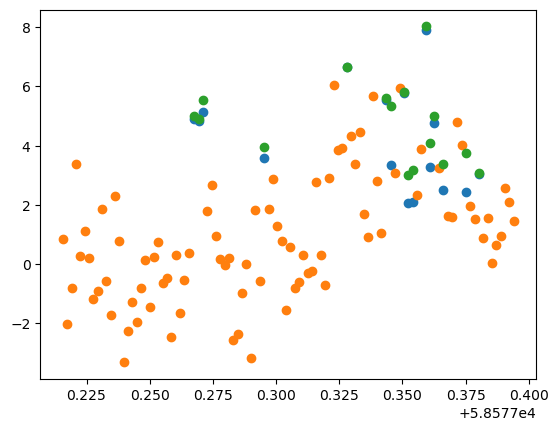

In [114]:
plt.scatter(times[mask], line_meas[mask]['forced_SNR'])
plt.scatter(times[~mask], line_meas[~mask]['forced_SNR'])
plt.scatter(times[mask], points_meas['forced_SNR'])
plt.show()

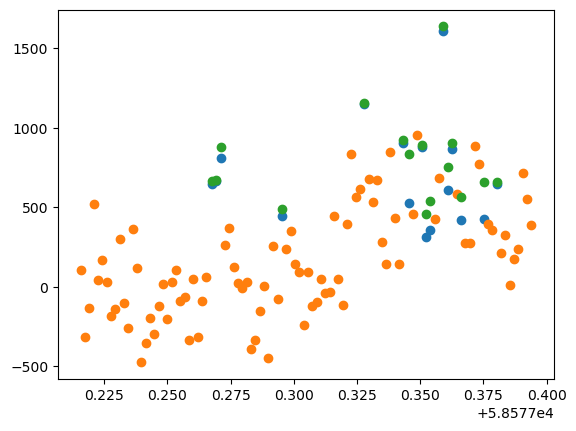

In [118]:
plt.scatter(times[mask], line_meas[mask]['forced_flux_zp'])
plt.scatter(times[~mask], line_meas[~mask]['forced_flux_zp'])
plt.scatter(times[mask], points_meas['forced_flux_zp'])
plt.show()

In [156]:
cutouts = []
for e, p in zip(exposures, points):
    cutouts.append(e.getCutout(p, lsst.geom.Extent2I(50, 50)))
    
cutouts = np.array(cutouts)

In [145]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend("matplotlib")

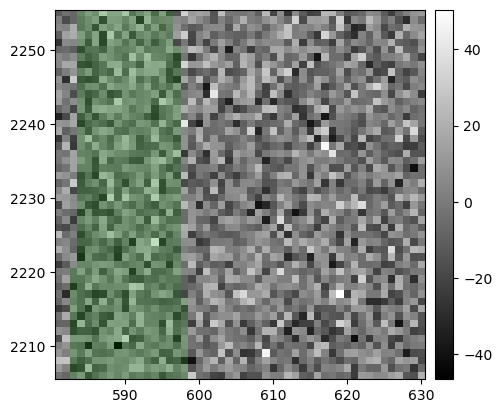

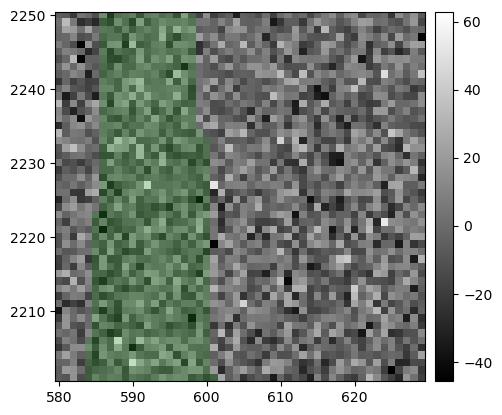

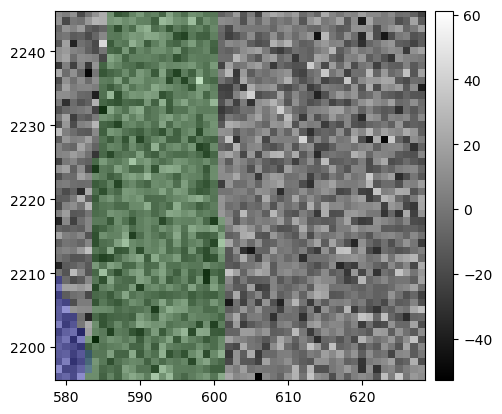

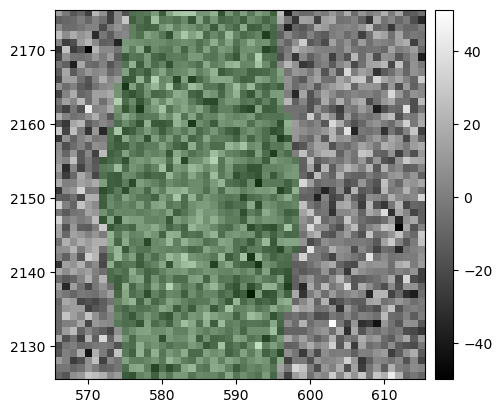

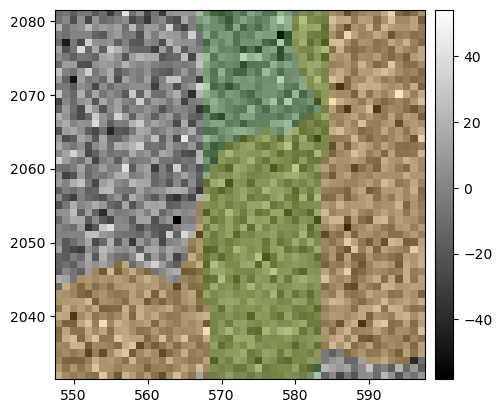

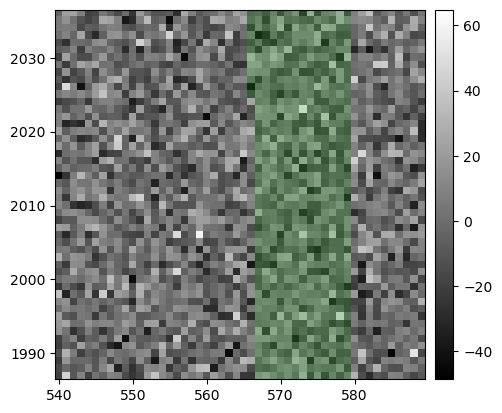

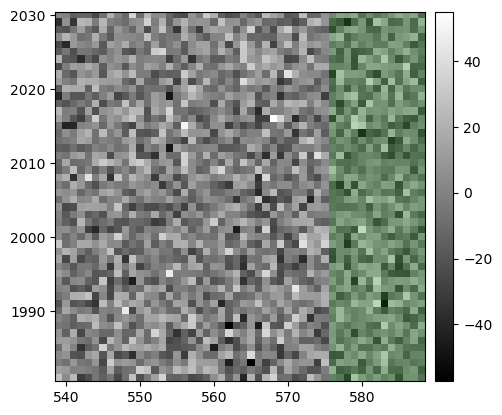

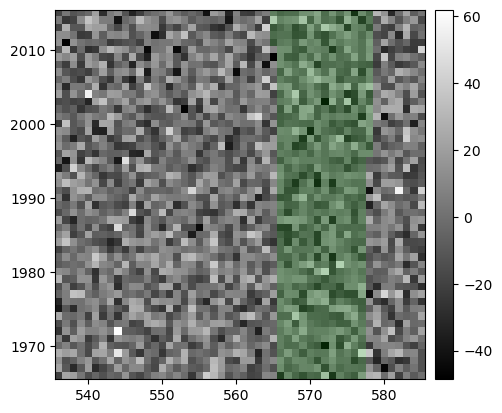

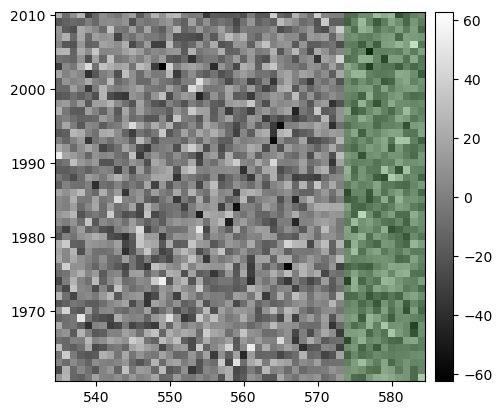

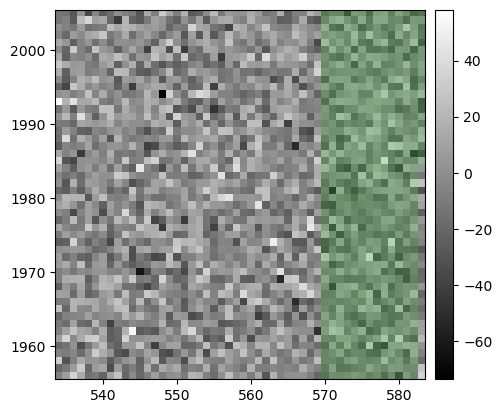

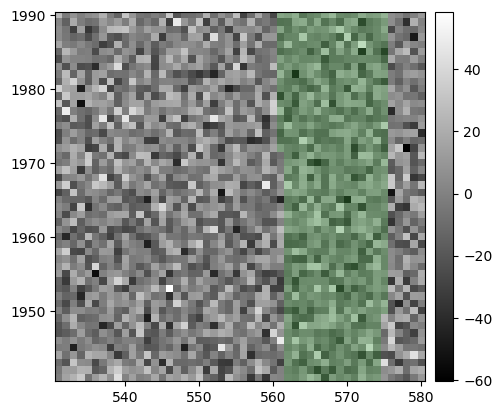

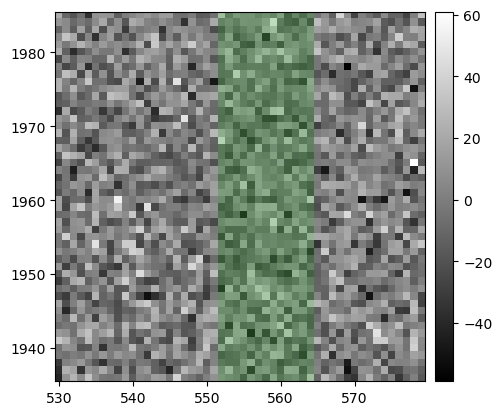

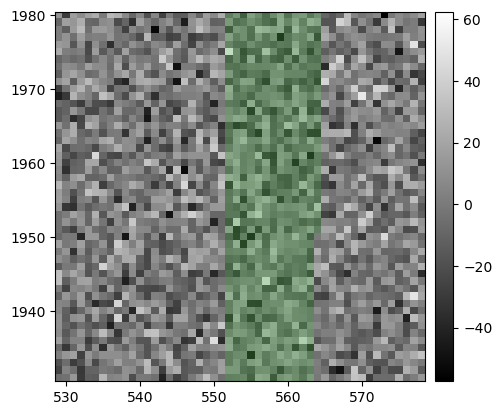

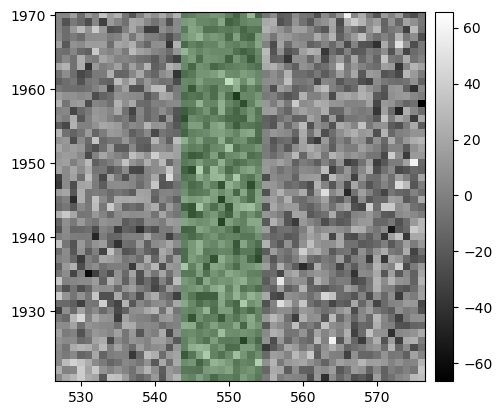

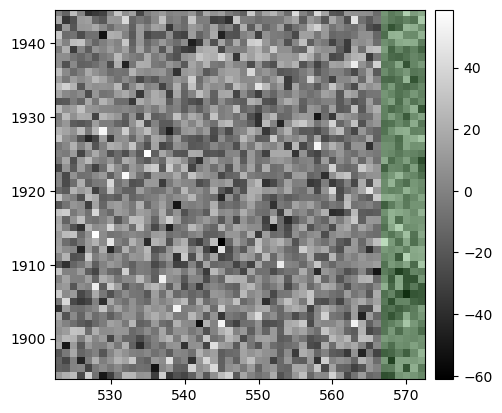

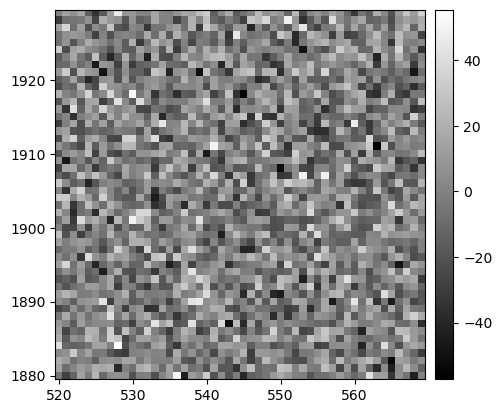

In [171]:
for c in cutouts[mask]:
    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.mtv(c)
    plt.show()

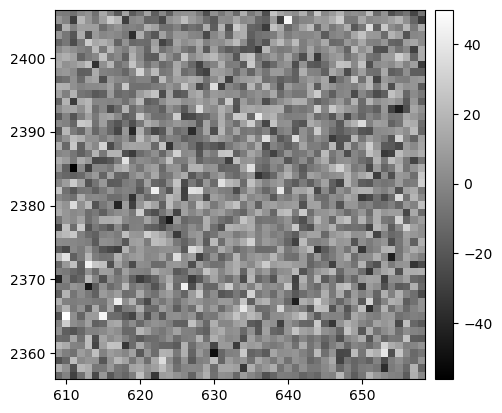

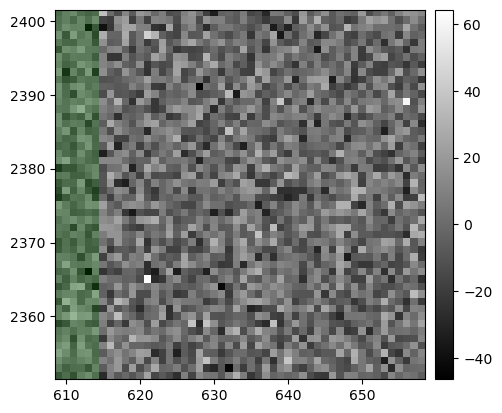

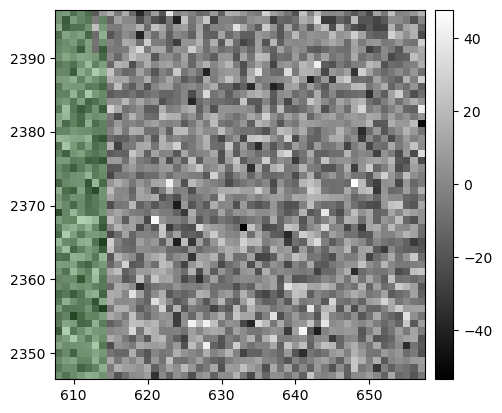

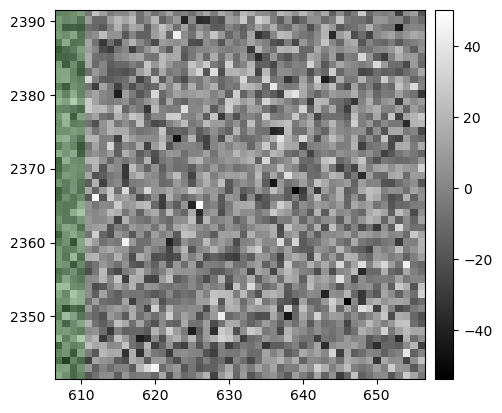

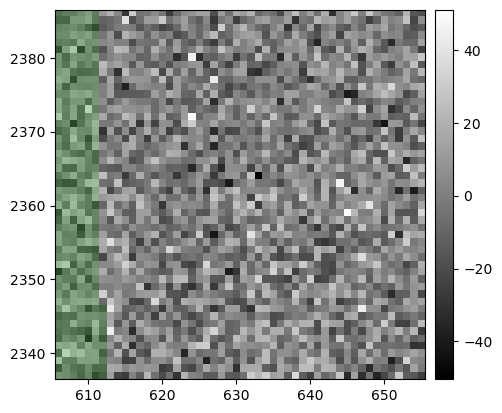

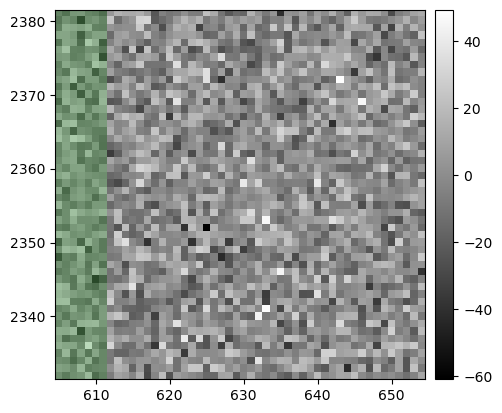

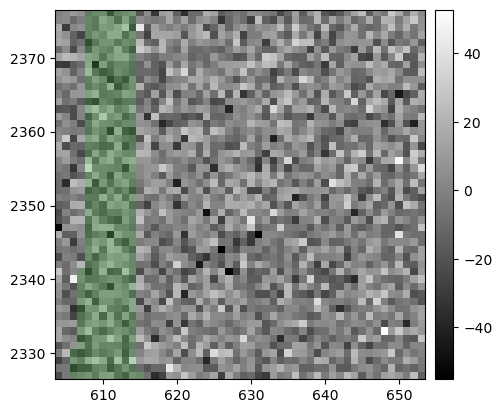

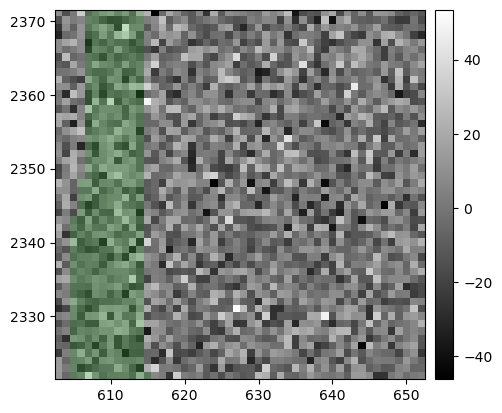

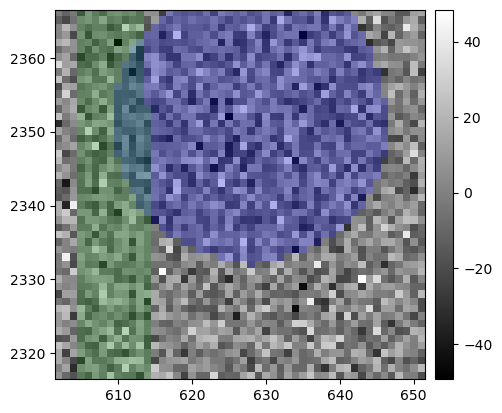

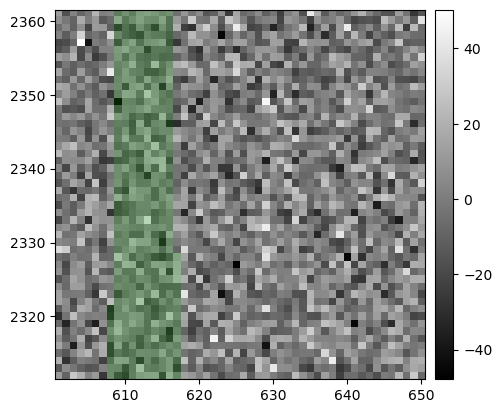

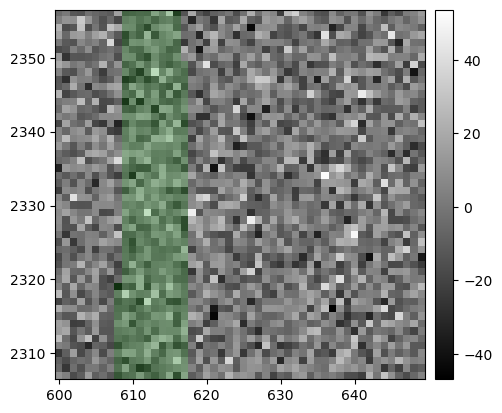

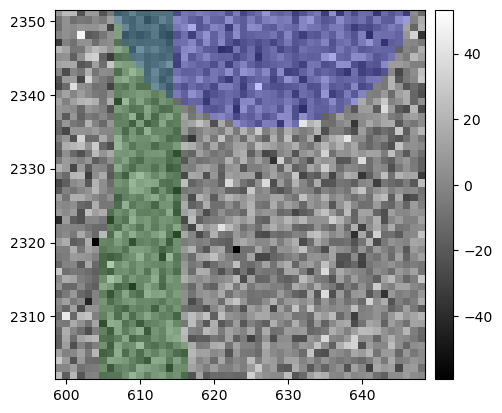

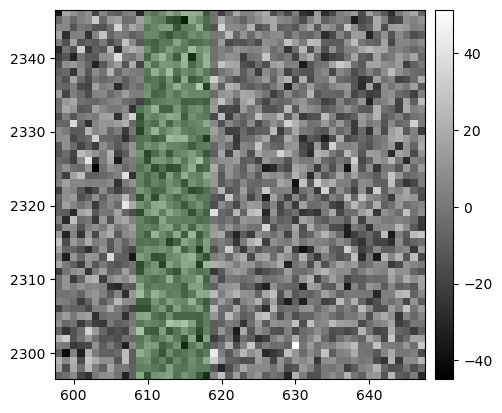

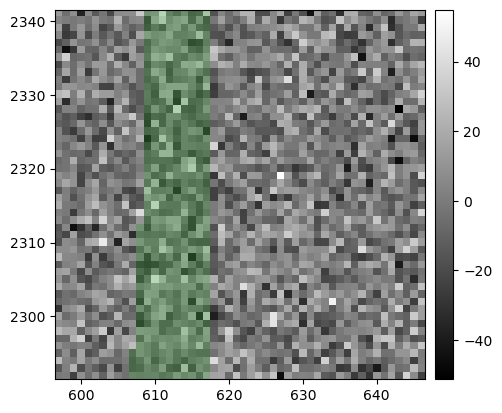

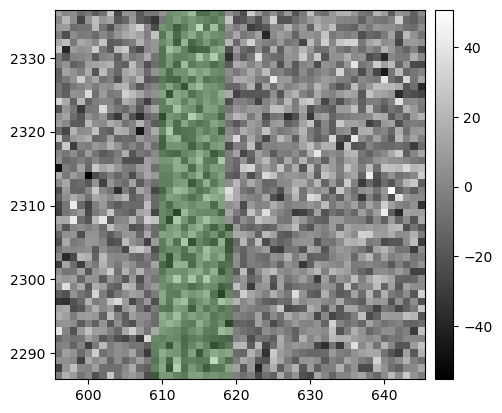

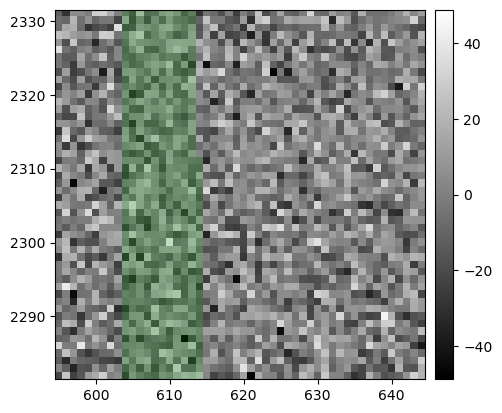

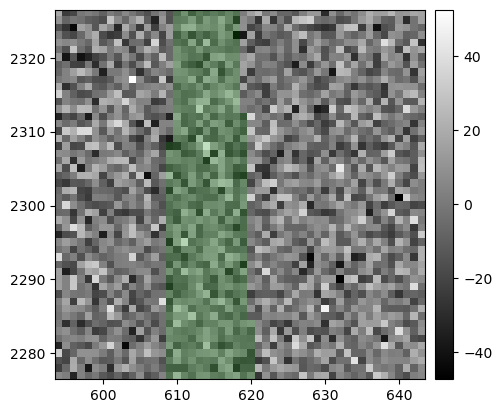

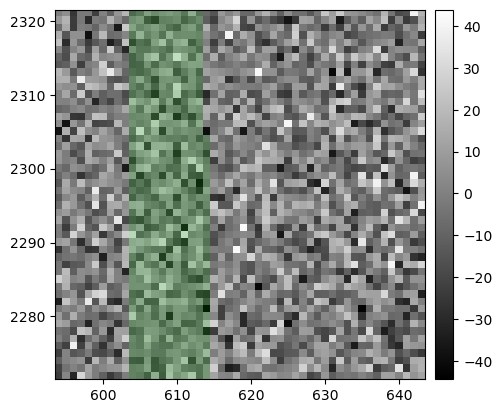

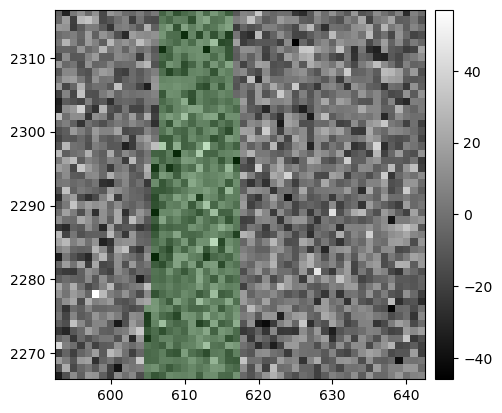

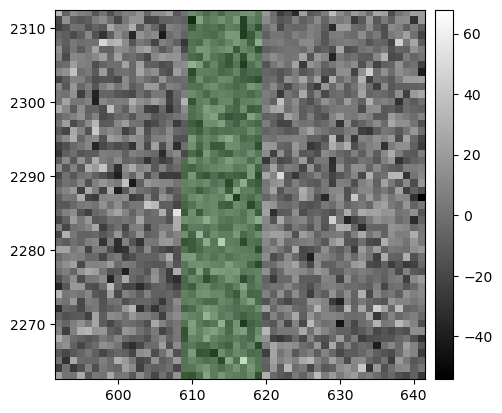

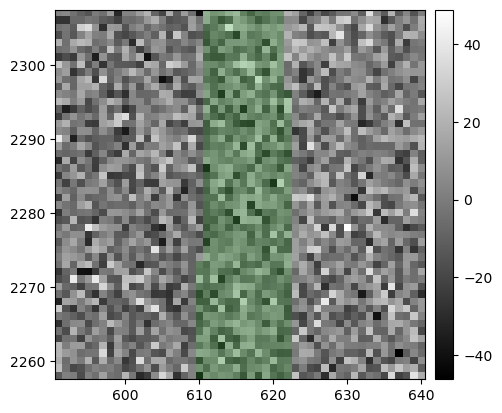

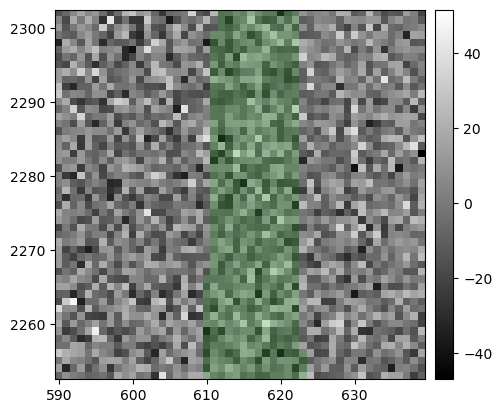

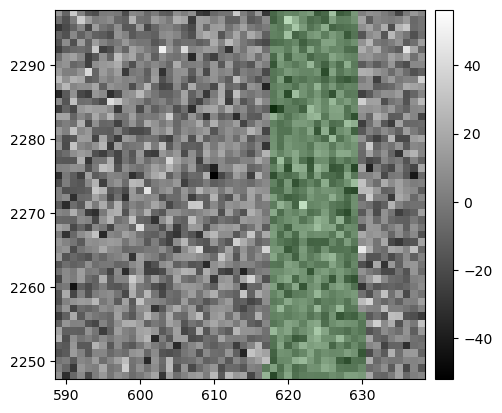

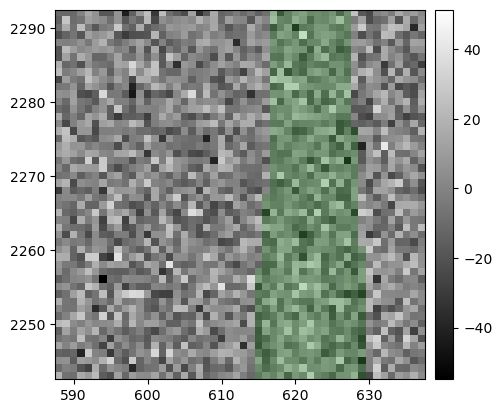

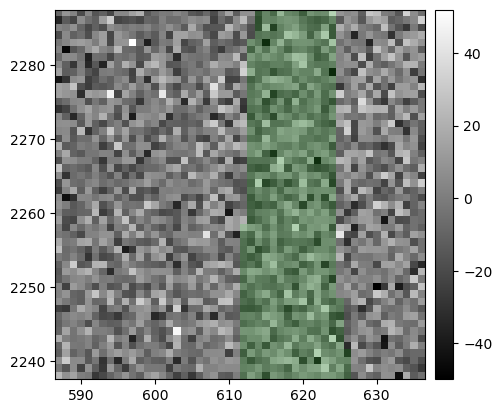

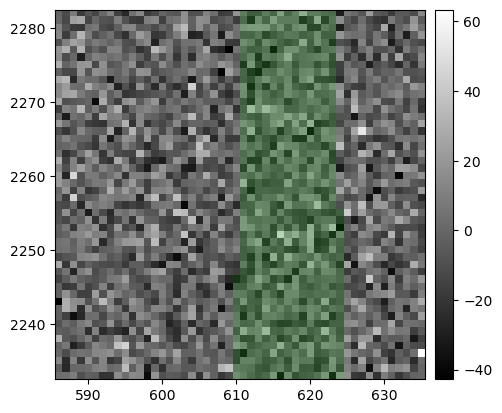

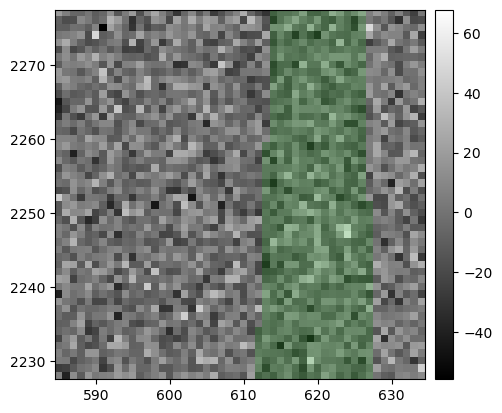

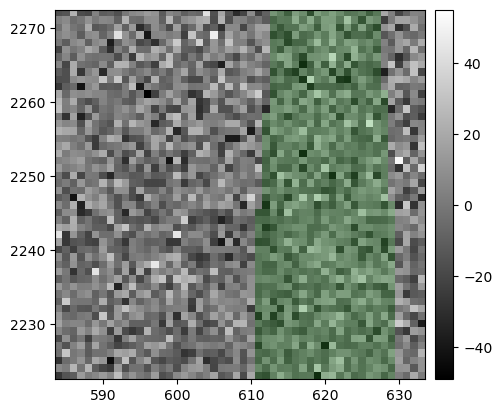

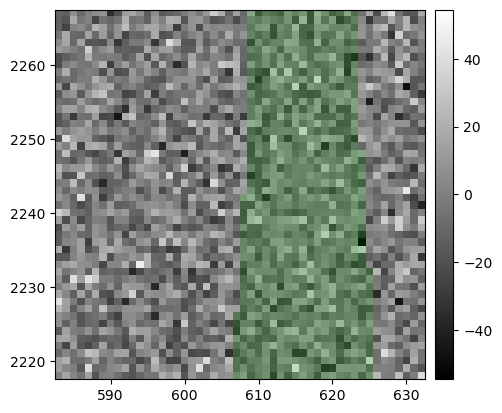

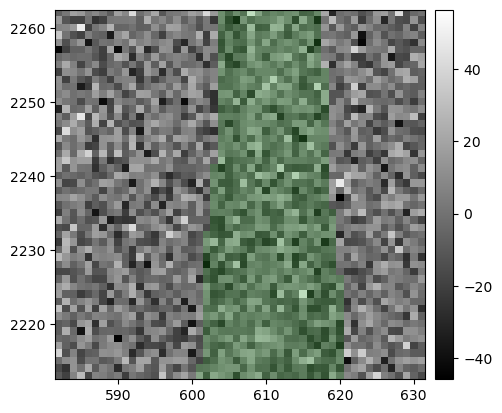

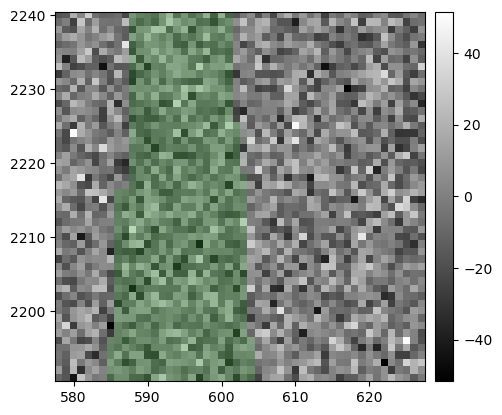

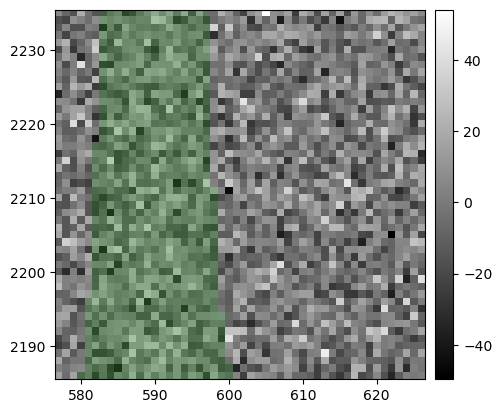

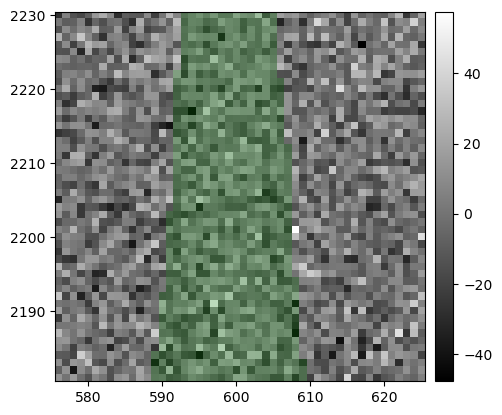

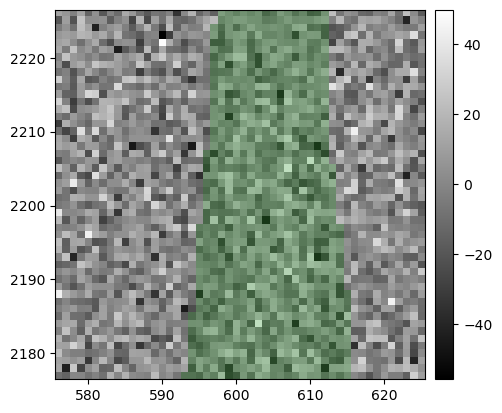

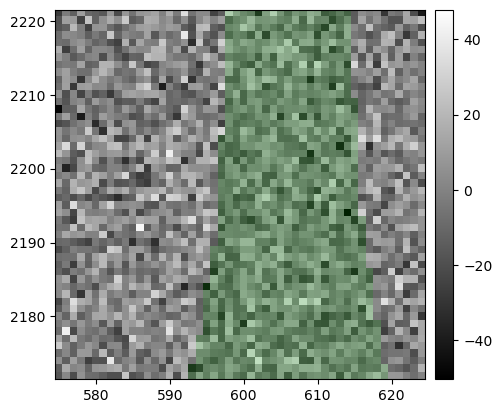

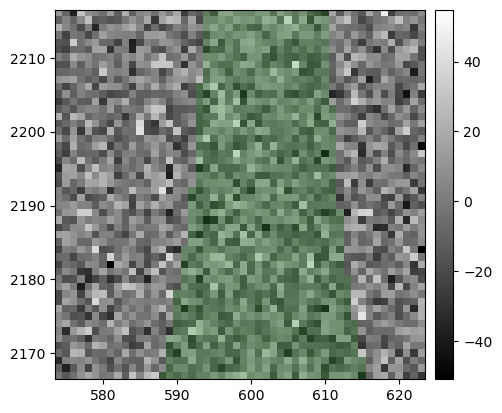

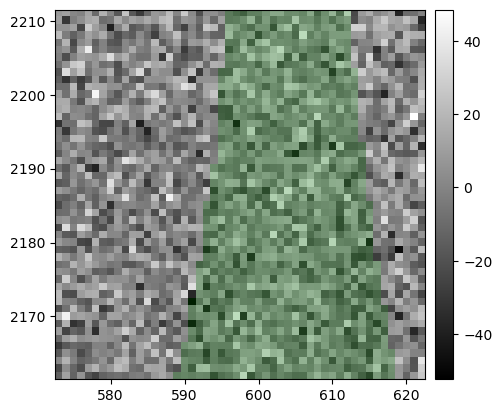

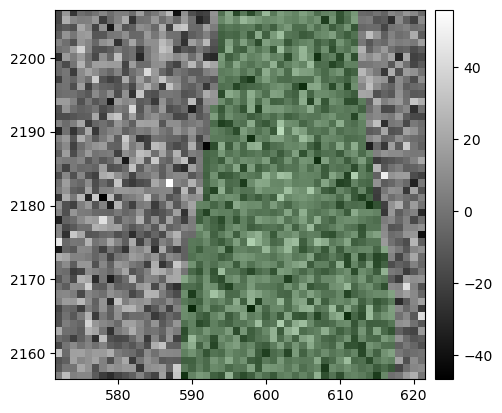

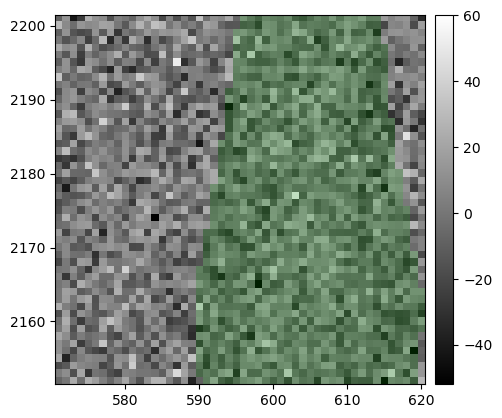

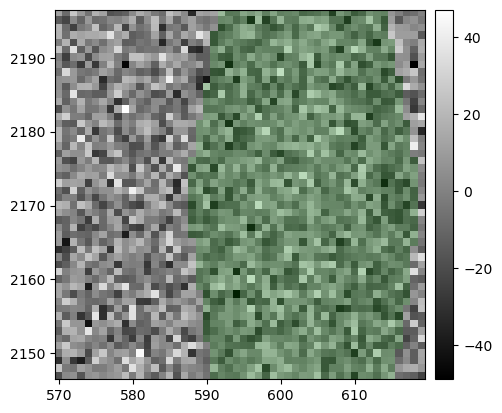

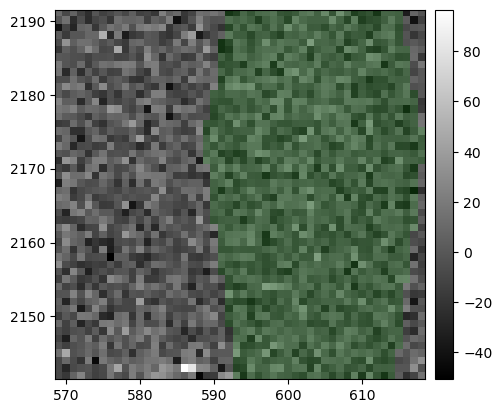

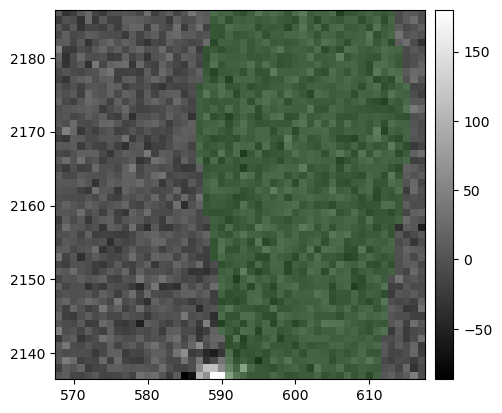

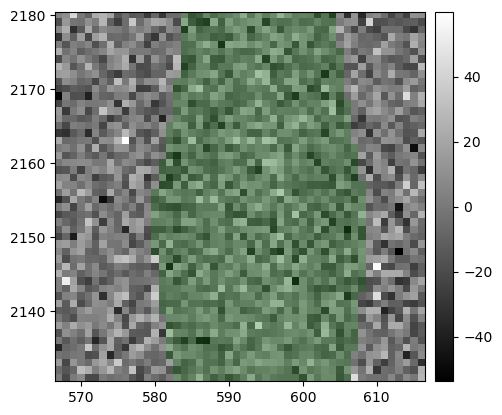

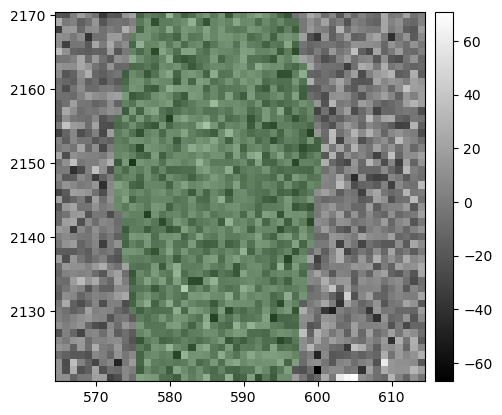

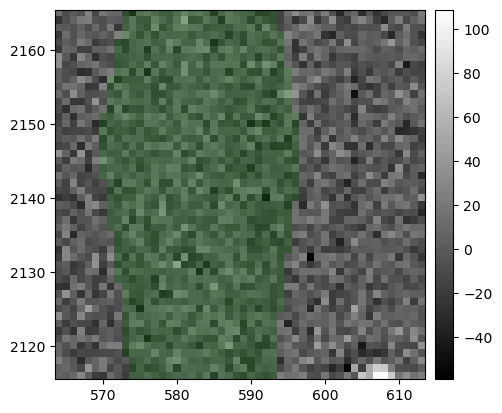

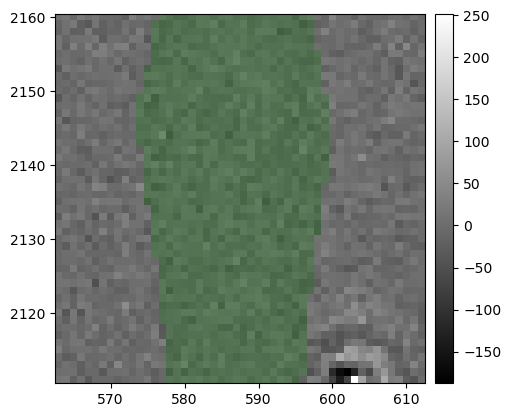

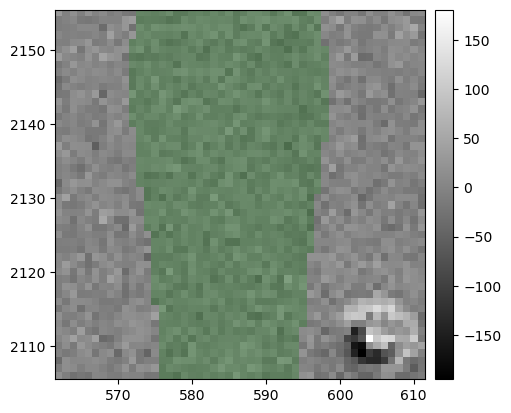

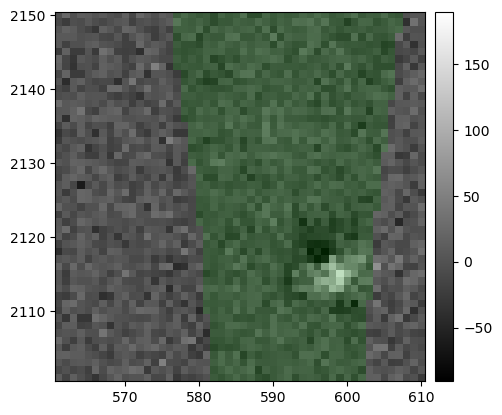

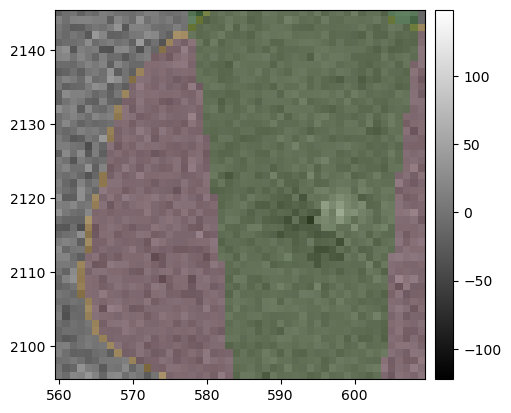

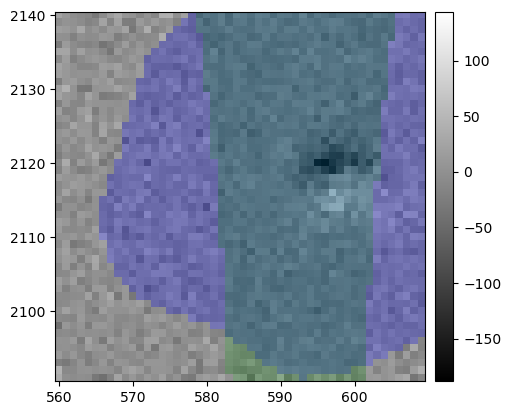

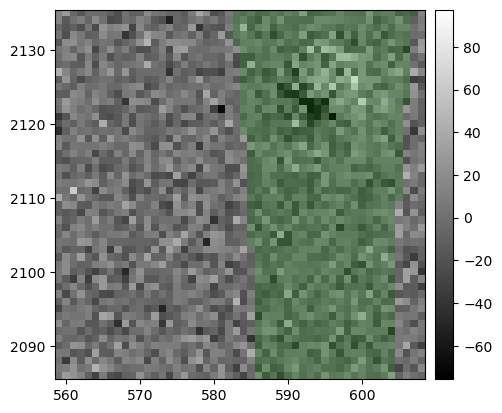

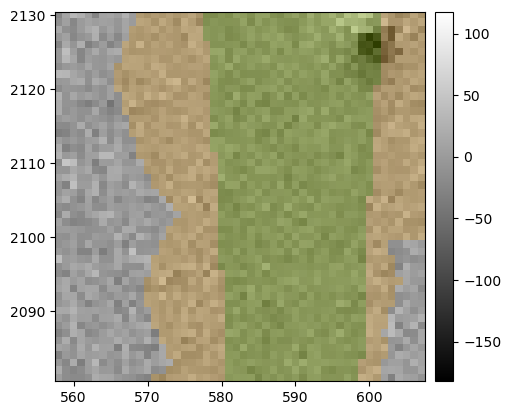

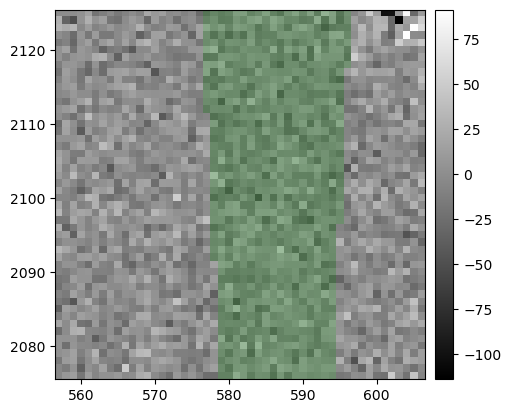

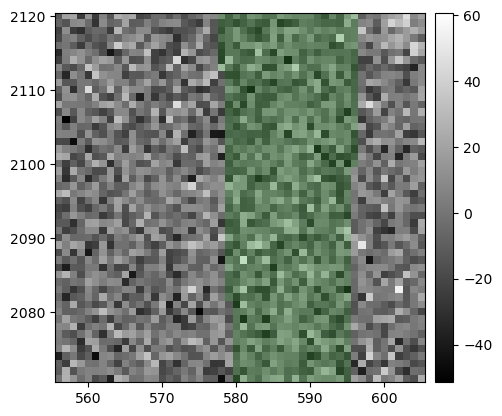

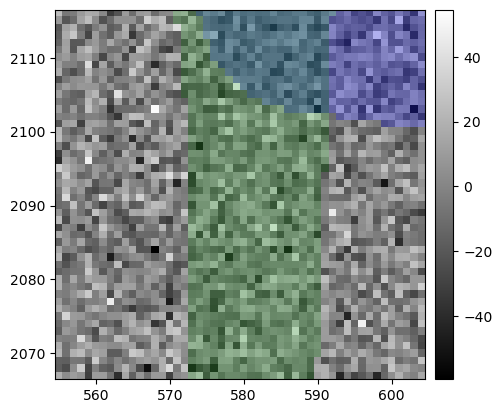

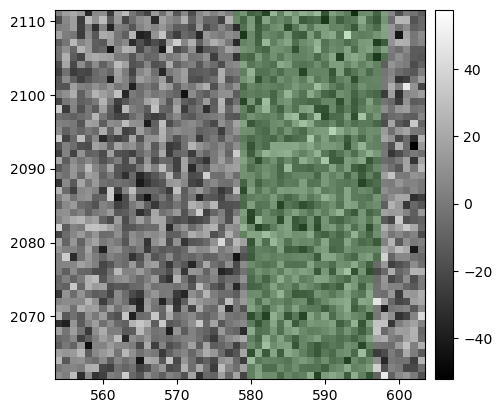

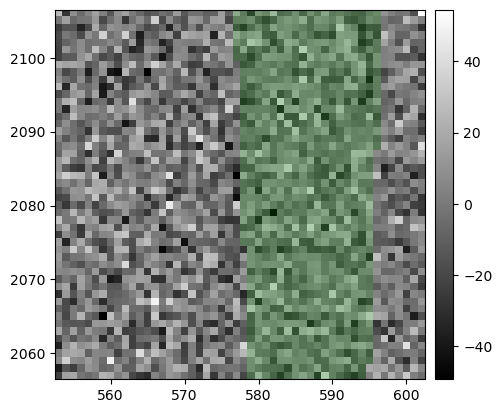

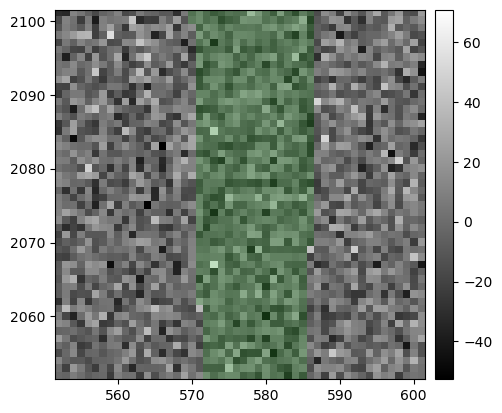

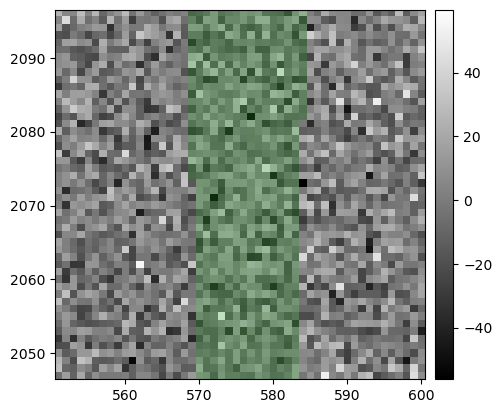

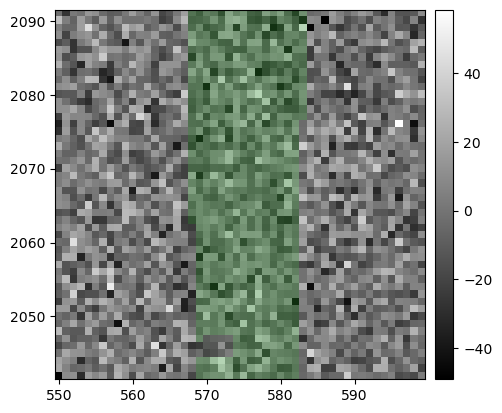

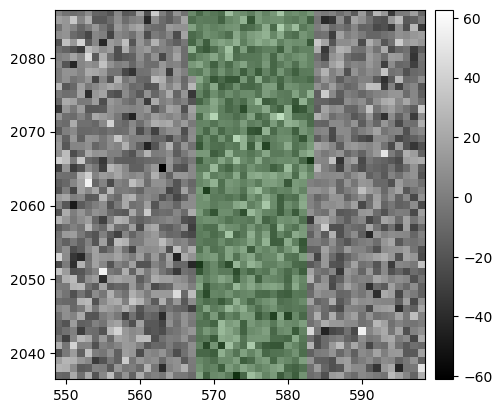

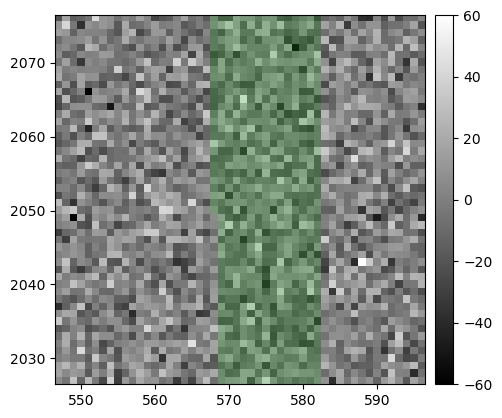

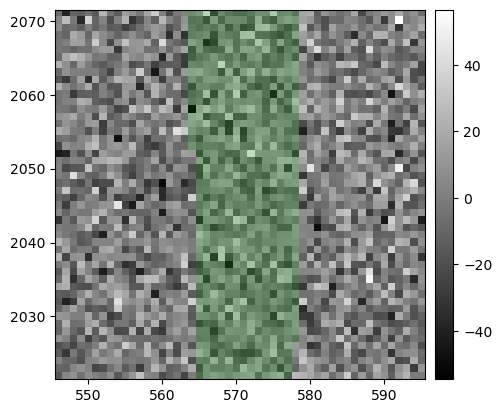

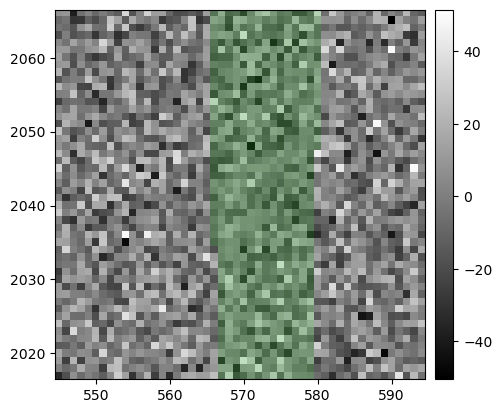

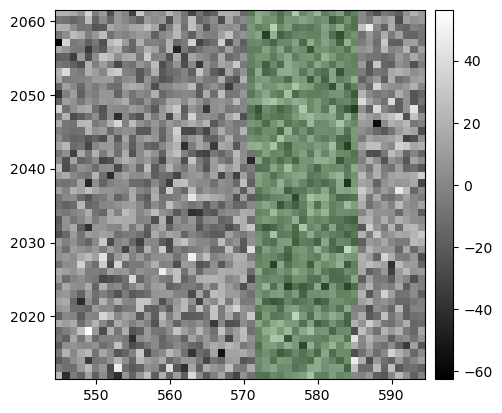

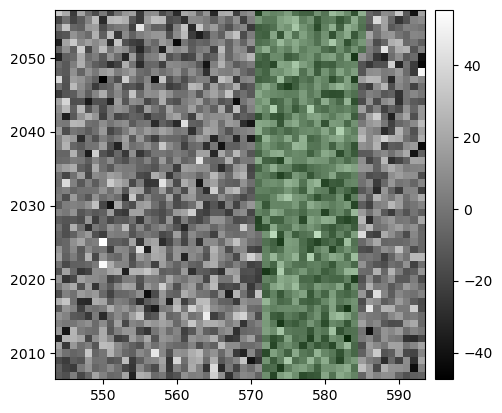

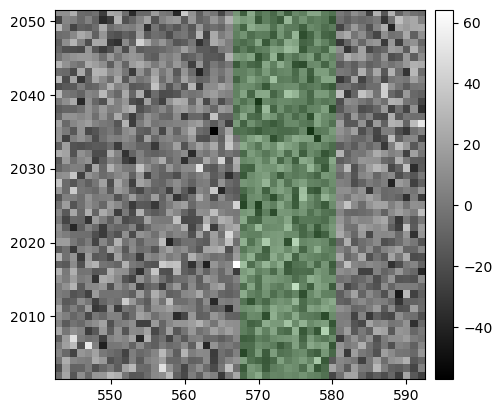

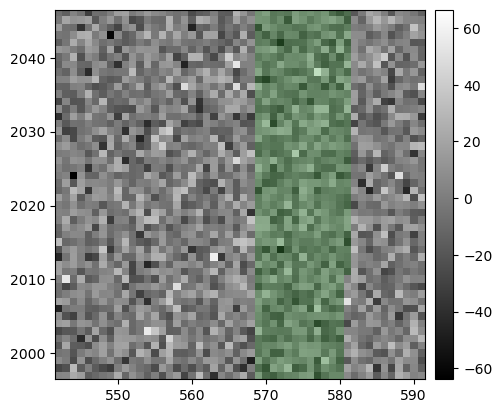

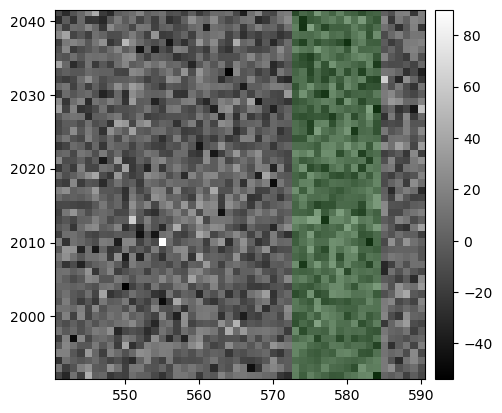

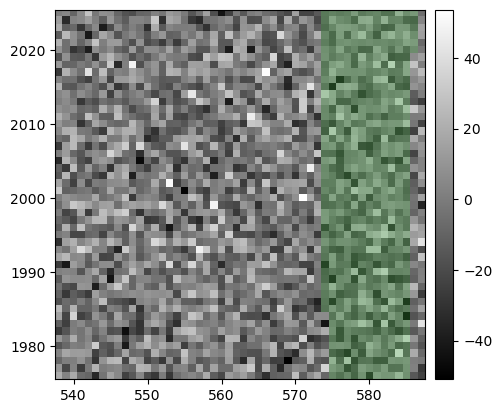

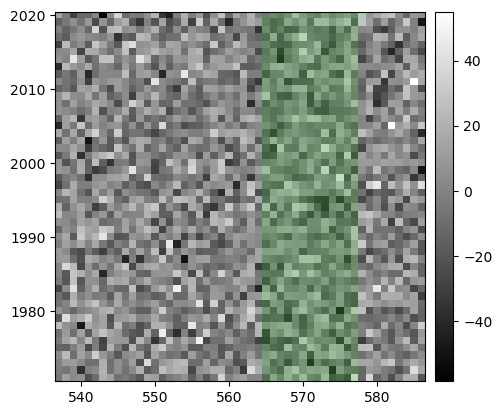

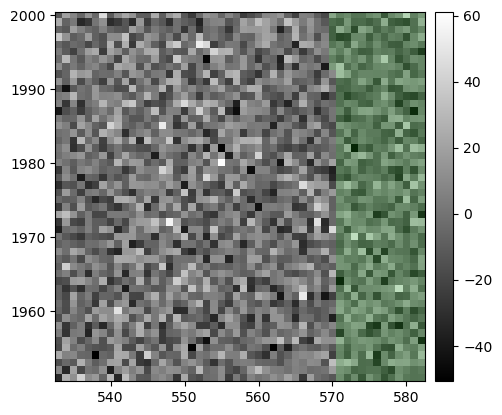

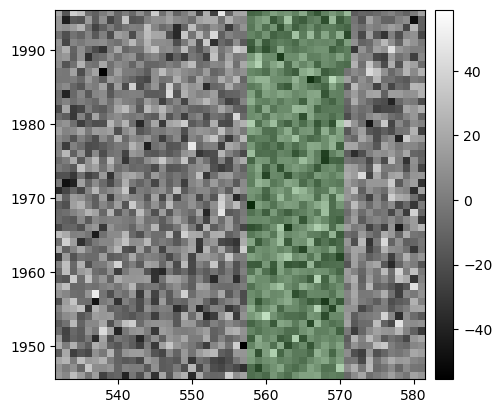

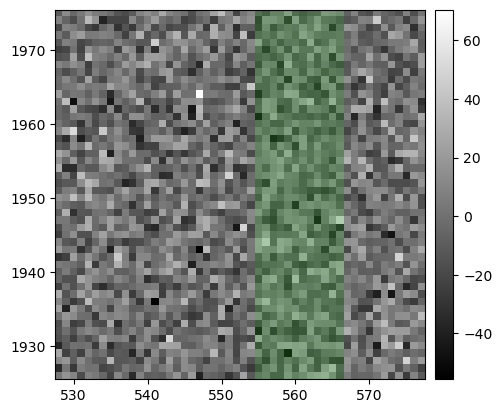

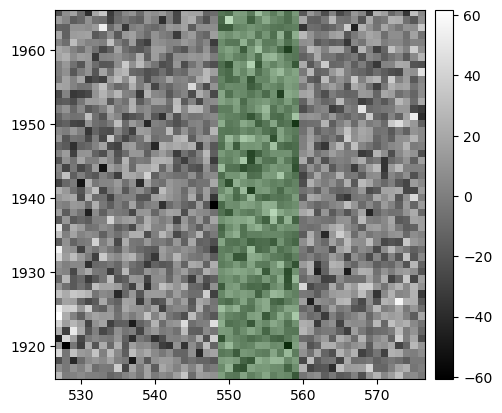

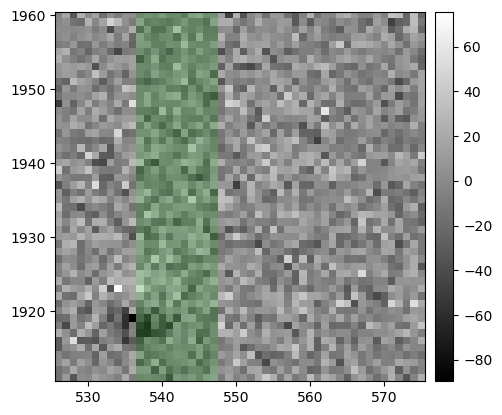

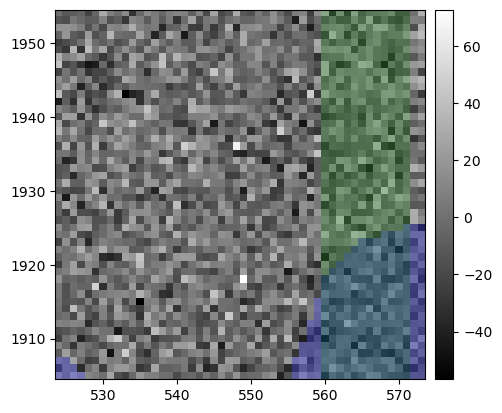

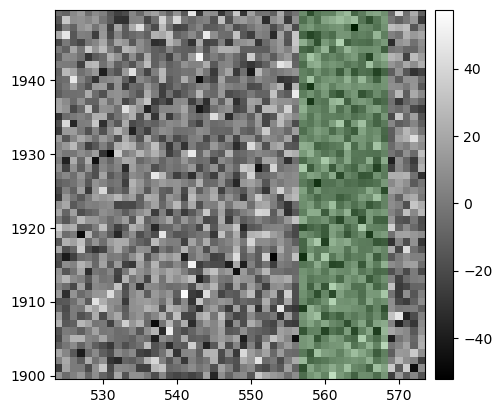

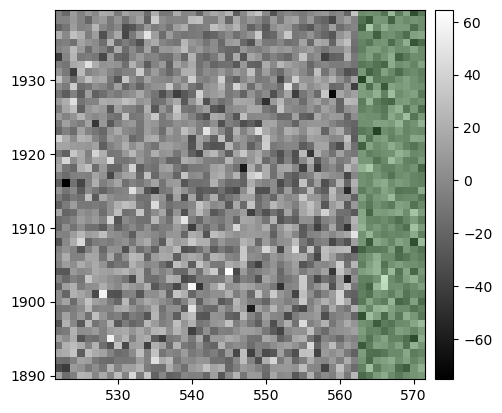

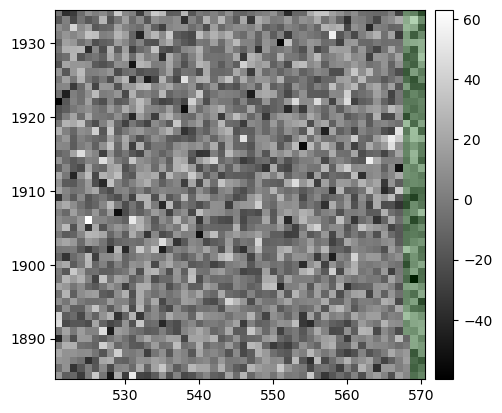

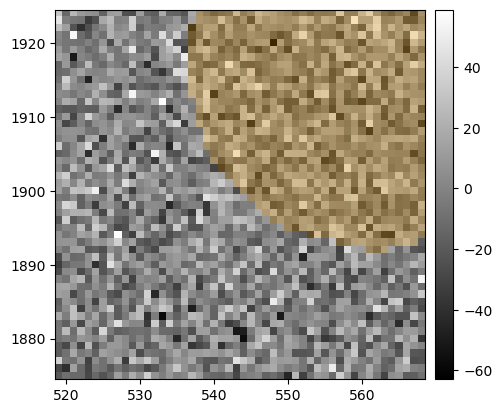

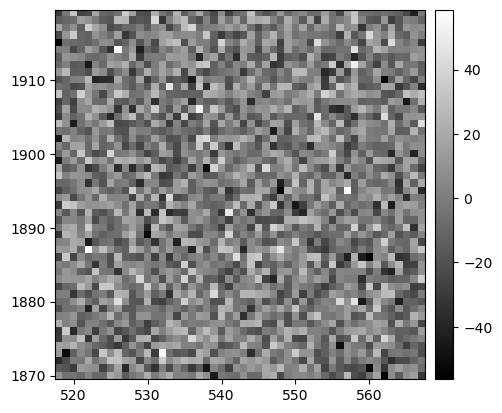

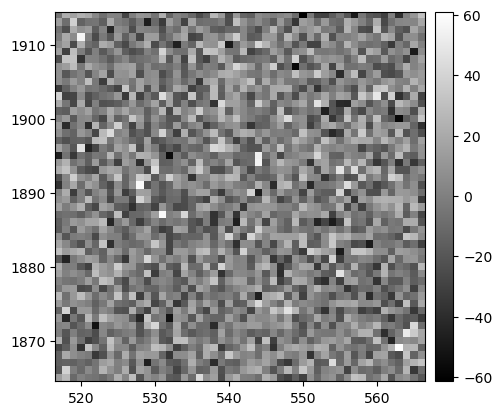

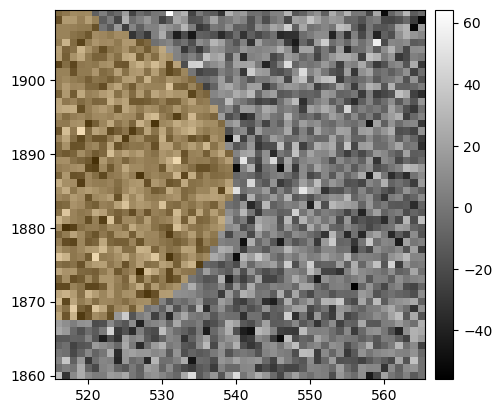

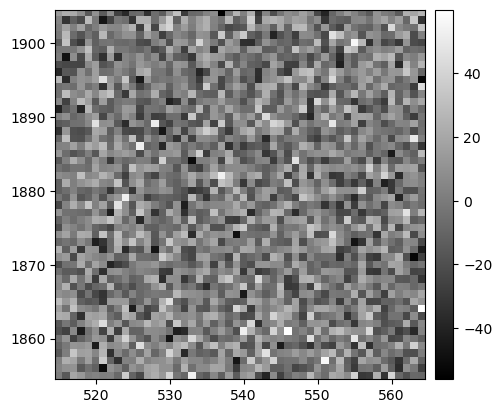

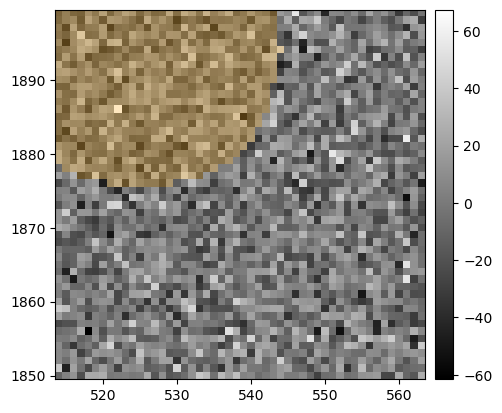

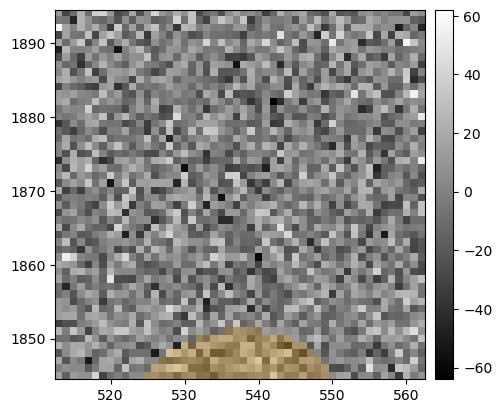

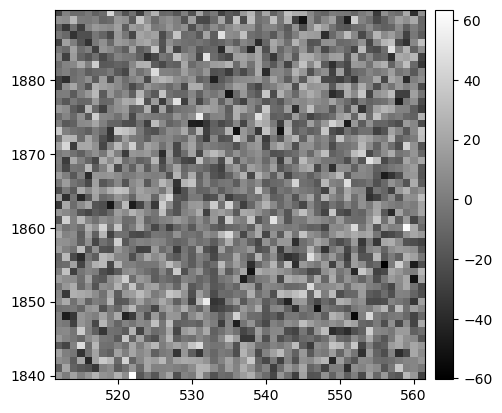

In [172]:
for c in cutouts[~mask]:
    fig = plt.figure()
    display = afwDisplay.Display(frame=fig)
    display.mtv(c)
    plt.show()

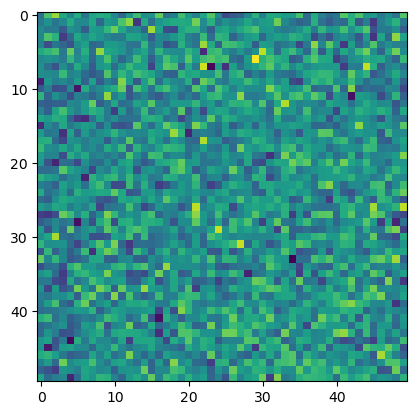

In [178]:
plt.imshow(sum(map(lambda x : x.image.array, cutouts[mask])) / mask.sum())
plt.show()

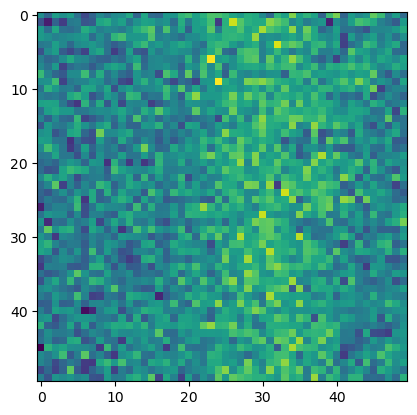

In [179]:
plt.imshow(sum(map(lambda x : x.image.array, cutouts[~mask])) / mask.sum())
plt.show()

In [120]:
flux = line_meas[mask]['forced_flux_zp']
sigma = line_meas[mask]['forced_sigma_zp']
coadd_snr = np.sum(
    flux/sigma**2
) / np.sum(
    1/sigma**2
)
coadd_snr

668.7486844817471

In [119]:
flux = line_meas[~mask]['forced_flux_zp']
sigma = line_meas[~mask]['forced_sigma_zp']
coadd_snr = np.sum(
    flux/sigma**2
) / np.sum(
    1/sigma**2
)
coadd_snr

128.05943271064586

In [121]:
(~mask).sum()

88

In [44]:
astropy.table.join(
    astropy.table.Table(cluster.points), 
    astropy.table.Table(data={"time": times, "expnum": expnums}),
    keys_left=['col2'],
    keys_right=['time']
)

col0,col1,col2,time,expnum
,,,d,
float64,float64,float64,float64,int64
216.14562500919843,-11.034169915161103,58577.27105676662,58577.27105676662,845904


In [19]:
# get the exposures that the cluster was detected in
cluster.points
# get the exposures that the cluster was not detected in

array([[ 2.16129350e+02, -1.10308111e+01,  5.85773454e+04],
       [ 2.16128398e+02, -1.10308290e+01,  5.85773506e+04],
       [ 2.16121989e+02, -1.10296106e+01,  5.85773802e+04],
       [ 2.16129958e+02, -1.10310081e+01,  5.85773433e+04],
       [ 2.16127518e+02, -1.10304465e+01,  5.85773540e+04],
       [ 2.16126634e+02, -1.10305130e+01,  5.85773592e+04],
       [ 2.16140471e+02, -1.10330421e+01,  5.85772953e+04],
       [ 2.16126113e+02, -1.10301997e+01,  5.85773609e+04],
       [ 2.16145625e+02, -1.10341699e+01,  5.85772711e+04],
       [ 2.16133302e+02, -1.10317389e+01,  5.85773279e+04],
       [ 2.16128027e+02, -1.10304848e+01,  5.85773523e+04],
       [ 2.16125030e+02, -1.10299951e+01,  5.85773661e+04],
       [ 2.16146183e+02, -1.10341682e+01,  5.85772676e+04],
       [ 2.16125856e+02, -1.10302537e+01,  5.85773626e+04],
       [ 2.16123062e+02, -1.10295506e+01,  5.85773751e+04],
       [ 2.16145878e+02, -1.10340812e+01,  5.85772693e+04]])